# 📓 Notebook SENSOR - Exploración de la clase Sensor (OOP)

## IMPORTANTE
Este notebook es **provisional/experimental**. La clase Sensor aún **NO está activa** en el código.

## Objetivos:
1. Entender la clase `Sensor` y sus ventajas
2. Comparar enfoque actual (dicts + DataFrames) vs OOP
3. Probar funcionalidades: metadata, validación, offsets
4. Visualizar cómo se integraría en Run/Set/Tree

## Documentación:
- Código completo: `src/sensor.py`
- Guía de uso: `docs/SENSOR_USAGE_EXAMPLE.md`

---
**Nota:** Este es un diseño para futura refactorización. Por ahora, solo exploración.

In [1]:
# Configurar el path para importar módulos locales
import sys
from pathlib import Path

project_root = Path('..').resolve().parent
sys.path.insert(0, str(project_root))

print(f'Path configurado: {project_root}')

Path configurado: /Users/vicky/Desktop/rtd-calib-simple


In [2]:
# Importar la clase Sensor (experimental)
from RTD_Calibration.src.sensor import Sensor, create_sensors_from_mapping
from RTD_Calibration.src.logfile import Logfile
from RTD_Calibration.src.run import Run
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(' Módulos importados correctamente')
print('   - Sensor (clase OOP)')
print('   - Run (código actual)')

 Módulos importados correctamente
   - Sensor (clase OOP)
   - Run (código actual)


## Parte 1: Crear un Run (código actual)

Primero cargamos un run usando el código actual para tener datos reales.

In [3]:
# Cargar logfile
repo_root = Path('..').resolve()
logfile_path = repo_root / 'data' / 'LogFile.csv'
logfile = Logfile(filepath=str(logfile_path))
logfile_df = logfile.log_file

print(f'Logfile cargado: {len(logfile_df)} entradas')

# Crear un run
filename = "20220201_ln2_r48176_r48177_487178-48189_1"
run = Run(filename=filename, logfile=logfile_df)

print(f'\nRun creado:')
print(f'   Archivo: {filename}')
print(f'   Sensores: {len(run.sensor_mapping)}')
print(f'   Datos: {run.temperature_data.shape}')

CSV file loaded successfully from '/Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/data/LogFile.csv'.
Logfile cargado: 832 entradas
Cargando: /Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/data/temperature_files/RTD_Calibs/CalSetN_1/20220201_ln2_r48176_r48177_487178-48189_1.txt
  Datos cargados: 692 registros
  Sensores asociados: 14

Run creado:
   Archivo: 20220201_ln2_r48176_r48177_487178-48189_1
   Sensores: 14
   Datos: (692, 14)


## Parte 2: Crear objetos Sensor desde el Run

Ahora vamos a crear objetos `Sensor` a partir del run actual.

In [4]:
# Crear sensores usando la función helper
sensors = create_sensors_from_mapping(
    sensor_mapping=run.sensor_mapping,
    temperature_data=run.temperature_data,
    config=run.config
)

print(f' {len(sensors)} objetos Sensor creados\n')

# Mostrar los primeros 3
for sensor in sensors[:3]:
    print(f'   {sensor}')

 14 objetos Sensor creados

   Sensor 48178 [channel_1]: 76.58K ± 0.017K
   Sensor 48179 [channel_2]: 76.57K ± 0.016K
   Sensor 48180 [channel_3]: 76.56K ± 0.015K


## 📋 Parte 3: Enriquecer con Metadata

La clase Sensor puede almacenar metadata del logfile.

In [5]:
# Enriquecer cada sensor con metadata del run
for sensor in sensors:
    sensor.enrich_from_metadata(run.metadata)

print(' Sensores enriquecidos con metadata\n')

# Mostrar información detallada
print(' Sensores con metadata:')
for sensor in sensors[:4]:
    print(f'\n{sensor.id}:')
    print(f'   Set: {sensor.set_number}')
    print(f'   Referencia: {"✓" if sensor.is_reference else "✗"}')
    print(f'   Fecha: {sensor.run_date}')
    print(f'   Medio: {sensor.liquid_media}')
    print(f'   Temperatura: {sensor.mean_temp:.2f}K ± {sensor.std_temp:.3f}K')

 Sensores enriquecidos con metadata

 Sensores con metadata:

48178:
   Set: 1
   Referencia: ✗
   Fecha: 01/02/2022
   Medio: LN2
   Temperatura: 76.58K ± 0.017K

48179:
   Set: 1
   Referencia: ✗
   Fecha: 01/02/2022
   Medio: LN2
   Temperatura: 76.57K ± 0.016K

48180:
   Set: 1
   Referencia: ✗
   Fecha: 01/02/2022
   Medio: LN2
   Temperatura: 76.56K ± 0.015K

48181:
   Set: 1
   Referencia: ✗
   Fecha: 01/02/2022
   Medio: LN2
   Temperatura: 76.60K ± 0.017K


##  Parte 4: Validación automática

Los sensores pueden validarse a sí mismos.

In [6]:
# Validar todos los sensores
print(' Validación de sensores:\n')

defective = []
unstable = []

for sensor in sensors:
    if sensor.is_defective():
        defective.append(sensor)
        print(f'  Sensor {sensor.id} DEFECTUOSO: {sensor._defective_reason}')
    
    if not sensor.is_stable(20, 40, threshold=0.1):
        unstable.append(sensor)
        print(f'  Sensor {sensor.id} INESTABLE (std > 0.1K en ventana 20-40 min)')

if not defective and not unstable:
    print(' Todos los sensores están OK')

print(f'\nResumen:')
print(f'   Total: {len(sensors)}')
print(f'   Defectuosos: {len(defective)}')
print(f'   Inestables: {len(unstable)}')
print(f'   Buenos: {len(sensors) - len(defective) - len(unstable)}')

 Validación de sensores:

 Todos los sensores están OK

Resumen:
   Total: 14
   Defectuosos: 0
   Inestables: 0
   Buenos: 14


##  Parte 5: Calcular offsets entre sensores

Cada sensor puede calcular su offset respecto a otro.

In [7]:
# Encontrar sensores de referencia
ref_sensors = [s for s in sensors if s.is_reference]

print(f' Sensores de referencia: {[s.id for s in ref_sensors]}\n')

# Calcular offsets de todos los sensores respecto a la primera referencia
if ref_sensors:
    ref = ref_sensors[0]
    print(f'📊 Offsets respecto a referencia {ref.id} (ventana 20-40 min):\n')
    
    offsets_data = []
    
    for sensor in sensors:
        if sensor.id != ref.id:
            offset, error = sensor.offset_to(ref, 20, 40)
            offsets_data.append({
                'sensor_id': sensor.id,
                'offset': offset,
                'error': error
            })
            print(f'   Sensor {sensor.id}: {offset:+.4f} ± {error:.4f} K')
    
    # Crear DataFrame para análisis
    offsets_df = pd.DataFrame(offsets_data)
    print(f'\n DataFrame de offsets creado: {offsets_df.shape}')

 Sensores de referencia: [48176, 48177]

📊 Offsets respecto a referencia 48176 (ventana 20-40 min):

   Sensor 48178: -0.0027 ± 0.0016 K
   Sensor 48179: -0.0137 ± 0.0016 K
   Sensor 48180: -0.0254 ± 0.0012 K
   Sensor 48181: +0.0158 ± 0.0012 K
   Sensor 48182: +0.0532 ± 0.0010 K
   Sensor 48183: -0.0414 ± 0.0030 K
   Sensor 48184: +0.0117 ± 0.0019 K
   Sensor 48185: +0.0460 ± 0.0018 K
   Sensor 48186: -0.0453 ± 0.0017 K
   Sensor 48187: -0.0473 ± 0.0022 K
   Sensor 48188: +0.0155 ± 0.0017 K
   Sensor 48189: +0.0234 ± 0.0018 K
   Sensor 48177: +0.0100 ± 0.0013 K

 DataFrame de offsets creado: (13, 3)


##  Parte 6: Visualización

Comparar el enfoque actual vs usar métodos de Sensor.

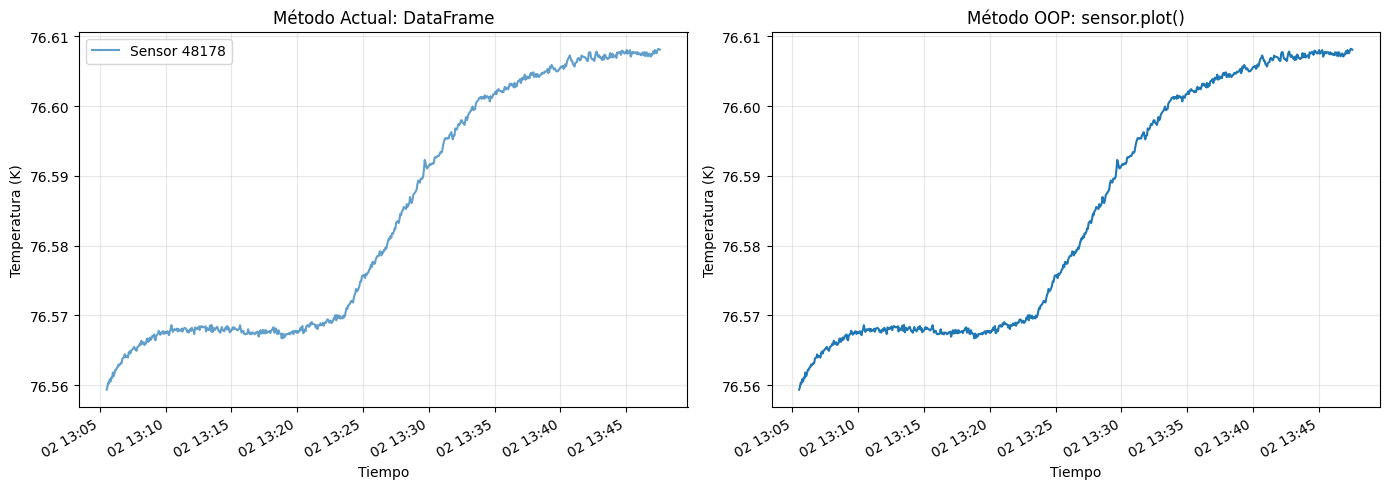

 Comparación visual generada
   Izquierda: Código actual (DataFrame)
   Derecha: Clase Sensor (método encapsulado)


In [8]:
# Método 1: Actual (usando DataFrame directamente)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Método actual
sensor_id = str(sensors[0].id)
run.temperature_data[sensor_id].plot(ax=ax1, label=f'Sensor {sensor_id}', alpha=0.7)
ax1.set_title('Método Actual: DataFrame')
ax1.set_xlabel('Tiempo')
ax1.set_ylabel('Temperatura (K)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Método OOP
sensors[0].plot(ax=ax2)
ax2.set_title('Método OOP: sensor.plot()')

plt.tight_layout()
plt.show()

print(' Comparación visual generada')
print('   Izquierda: Código actual (DataFrame)')
print('   Derecha: Clase Sensor (método encapsulado)')

##  Parte 7: Summary completo

El método `summary()` retorna toda la información del sensor.

In [9]:
# Obtener summary de un sensor
sensor = sensors[0]
summary = sensor.summary()

print(f' Summary completo del Sensor {sensor.id}:\n')

# Mostrar de forma organizada
categories = {
    'Identificación': ['id', 'channel'],
    'Estadísticas': ['mean', 'std', 'min', 'max', 'nan_count'],
    'Estado': ['is_defective', 'defective_reason', 'is_stable'],
    'Metadata': ['set_number', 'is_reference', 'run_date', 'liquid_media', 'board'],
    'Calibración': ['calibration_constant', 'calibration_error', 'calibration_paths']
}

for category, keys in categories.items():
    print(f'{category}:')
    for key in keys:
        value = summary.get(key)
        if value is not None:
            if isinstance(value, float):
                print(f'   {key}: {value:.4f}')
            else:
                print(f'   {key}: {value}')
    print()

# Convertir a DataFrame para análisis
print(' Exportar summaries a DataFrame:')
all_summaries = [s.summary() for s in sensors]
summary_df = pd.DataFrame(all_summaries)
print(summary_df[['id', 'mean', 'std', 'is_defective', 'is_reference']].head())

 Summary completo del Sensor 48178:

Identificación:
   id: 48178
   channel: channel_1

Estadísticas:
   mean: 76.5844
   std: 0.0172
   min: 76.5594
   max: 76.6082
   nan_count: 0

Estado:
   is_defective: False
   is_stable: True

Metadata:
   set_number: 1
   is_reference: False
   run_date: 01/02/2022
   liquid_media: LN2
   board: IFIC-B1

Calibración:
   calibration_paths: []

 Exportar summaries a DataFrame:
      id       mean       std  is_defective  is_reference
0  48178  76.584448  0.017248         False         False
1  48179  76.574415  0.016126         False         False
2  48180  76.562937  0.015483         False         False
3  48181  76.602779  0.017228         False         False
4  48182  76.640487  0.016856         False         False


##  Parte 8: Ejemplo de uso en análisis

Casos de uso prácticos con la clase Sensor.

In [ ]:
# 1. Filtrar sensores por características
print(' Filtrado avanzado:\n')

# Sensores buenos (no defectuosos y estables)
good_sensors = [s for s in sensors if not s.is_defective() and s.is_stable()]
print(f'   Sensores buenos: {len(good_sensors)}/{len(sensors)}')

# Sensores de referencia
refs = [s for s in sensors if s.is_reference]
print(f'   Referencias: {[s.id for s in refs]}')

# Sensores con temperatura media alta
high_temp = [s for s in sensors if s.mean_temp > 76.6]
print(f'   Temperatura alta (>76.6K): {[s.id for s in high_temp]}')

print('\n Agrupar por estado:')
from collections import defaultdict

by_status = defaultdict(list)
for s in sensors:
    if s.is_defective():
        status = 'defective'
    elif not s.is_stable():
        status = 'unstable'
    elif s.is_reference:
        status = 'reference'
    else:
        status = 'good'
    by_status[status].append(s.id)

for status, ids in by_status.items():
    print(f'   {status.upper()}: {ids}')

print('\n Con Sensor puedes hacer filtros complejos.')

 Filtrado avanzado:

   Sensores buenos: 14/14
   Referencias: [48176, 48177]
   Temperatura alta (>76.6K): [48181, 48182, 48184, 48185, 48188, 48189]

 Agrupar por estado:
   GOOD: [48178, 48179, 48180, 48181, 48182, 48183, 48184, 48185, 48186, 48187, 48188, 48189]
   REFERENCE: [48176, 48177]

 Con Sensor puedes hacer filtros complejos fácilmente!


## Parte 9: Simular calibración (futuro)

Cómo se usaría en Set.py y Tree.py.

In [ ]:
# Simular actualización de calibración (como se haría en Tree)
print(' Simulación de calibración en Tree:\n')

# Sensor a calibrar (no referencia)
target_sensor = next(s for s in sensors if not s.is_reference)
print(f'Calibrando sensor {target_sensor.id}...')

# Simular cálculo de constante (ejemplo)
simulated_constant = 1.0234
simulated_error = 0.0012
simulated_paths = [f'{ref.id}->48180->48181->{target_sensor.id}' for ref in refs]

# Actualizar sensor con resultados
target_sensor.update_calibration(
    constant=simulated_constant,
    error=simulated_error,
    paths=simulated_paths
)

print(f' Calibración actualizada:')
print(f'   Constante: {target_sensor.calibration_constant:.4f}')
print(f'   Error: {target_sensor.calibration_error:.4f}')
print(f'   Caminos: {len(target_sensor.calibration_paths)}')

# Mostrar summary actualizado
print(f'\n Summary actualizado:')
summary = target_sensor.summary()
for key in ['calibration_constant', 'calibration_error', 'calibration_paths']:
    print(f'   {key}: {summary[key]}')

print('\n En Tree.py, cada sensor almacenaría sus resultados de calibración')

 Simulación de calibración en Tree:

Calibrando sensor 48178...
 Calibración actualizada:
   Constante: 1.0234
   Error: 0.0012
   Caminos: 2

 Summary actualizado:
   calibration_constant: 1.0234
   calibration_error: 0.0012
   calibration_paths: ['48176->48180->48181->48178', '48177->48180->48181->48178']

 En Tree.py, cada sensor almacenaría sus resultados de calibración!


##  Conclusiones y próximos pasos

###  Ventajas demostradas:
1. **Encapsulación**: Todo relacionado con el sensor está en un objeto
2. **Metadata integrada**: Set, fecha, referencia, calibración en un solo lugar
3. **Validación automática**: `is_defective()`, `is_stable()` con config
4. **Código más limpio**: `sensor.mean_temp` vs `df[id].mean()`
5. **Extensible**: Fácil añadir métodos sin tocar Run/Set/Tree

###  Recursos:
- Código completo: `src/sensor.py`
- Guía de activación: `docs/SENSOR_USAGE_EXAMPLE.md`
- Este notebook: Ejemplos interactivos

###  Para activar en el futuro:
1. Leer `docs/SENSOR_USAGE_EXAMPLE.md`
2. Copiar código de ejemplo en `run._associate_sensors()`
3. Testear con este notebook
4. Extender a Set y Tree gradualmente

---

**Nota final:** Este es un diseño provisional. La decisión de activarlo depende de:
- Preferencia arquitectónica (OOP vs funcional)
- Complejidad del proyecto a futuro
- Necesidad de extensibilidad

##  Experimento: Crea tus propios sensores

Usa esta celda para experimentar con la clase Sensor.

In [13]:
# Espacio para experimentación
# Ejemplo: Comparar dos sensores específicos

# Seleccionar dos sensores
s1 = sensors[0]
s2 = sensors[1]

print(f'Comparando {s1.id} vs {s2.id}:\n')

# Offset entre ellos
offset, error = s1.offset_to(s2, 20, 40)
print(f'Offset: {offset:.4f} ± {error:.4f} K')

# Estadísticas
print(f'\n{s1.id}:')
print(f'   Media: {s1.mean_temp:.2f}K')
print(f'   Std: {s1.std_temp:.4f}K')
print(f'   Estable: {s1.is_stable()}')

print(f'\n{s2.id}:')
print(f'   Media: {s2.mean_temp:.2f}K')
print(f'   Std: {s2.std_temp:.4f}K')
print(f'   Estable: {s2.is_stable()}')

# + código adicional aquí

Comparando 48178 vs 48179:

Offset: 0.0110 ± 0.0015 K

48178:
   Media: 76.58K
   Std: 0.0172K
   Estable: True

48179:
   Media: 76.57K
   Std: 0.0161K
   Estable: True
